# Lecture 17
_____________


In [13]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from scipy.optimize import differential_evolution
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 600
import numpy as np

## _Ishigami_

Define the problem

In [14]:
problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3 
}

Generate samples

In [17]:
param_values = saltelli.sample(problem, 1024)

/var/folders/d0/8bmn6nx130n6ljv_75rbjbnh0000gn/T/ipykernel_79343/1862108280.py:1: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


Run model (example)

In [20]:
Y = Ishigami.evaluate(param_values)

Perform analysis

In [21]:
Si = sobol.analyze(problem, Y, print_to_console=True)

          ST   ST_conf
x1  0.555860  0.088462
x2  0.441898  0.039723
x3  0.244675  0.025095
          S1   S1_conf
x1  0.316832  0.051658
x2  0.443763  0.052609
x3  0.012203  0.059444
                S2   S2_conf
(x1, x2)  0.009254  0.078927
(x1, x3)  0.238172  0.100622
(x2, x3) -0.004888  0.073359


Returns a dictionary with keys `S1`, `S1_conf`, `ST`, and `ST_conf` 
(first and total-order indices with bootstrap confidence intervals)

-----------

### Conceptual hydrologic model

`hymod` implementation following Gharari et al. HESS 2013

Load daily data for 1 year (precip, potential ET, and observed streamflow)

In [22]:
ndays = 365
data = np.loadtxt('data/leaf-river-data.txt', skiprows=1)
data_P = data[0:ndays,3]
data_PET = data[0:ndays,4]
data_Q = data[0:ndays,5]

In [23]:
def hymod(x, mode='optimize'):
    
    # assign parameters
    Sm_max,B,alpha,Kf,Ks = list(x)
    
    # initialize storage, all empty to start
    Sm,Sf1,Sf2,Sf3,Ss1 = [np.zeros(ndays) for _ in range(5)]
    Q = np.zeros(ndays)
    
    for t in range(1,ndays):
        
        # calculate all fluxes
        P = data_P[t]
        Peff = P*(1 - max(1-Sm[t-1]/Sm_max,0)**B) # PDM model Moore 1985
        Evap = min(data_PET[t]*(Sm[t-1]/Sm_max), Sm[t-1])
        
        Qf1 = Kf*Sf1[t-1]
        Qf2 = Kf*Sf2[t-1]
        Qf3 = Kf*Sf3[t-1]
        Qs1 = Ks*Ss1[t-1]
        
        # update state variables
        Sm[t] = Sm[t-1] + P - Peff - Evap
        Sf1[t] = Sf1[t-1] + alpha*Peff - Qf1
        Sf2[t] = Sf2[t-1] + Qf1 - Qf2
        Sf3[t] = Sf3[t-1] + Qf2 - Qf3
        Ss1[t] = Ss1[t-1] + (1-alpha)*Peff - Qs1
        
        Q[t] = Qs1 + Qf3
    
    if mode=='simulate':
        return Q
    else:
        return np.sqrt(np.sum((Q-data_Q)**2))


bounds = [(0,500), (0,2), (0,1), (0.1,1), (0,0.1)]

To calibrate parameters and plot

     fun: 21.40682690522882
 message: 'Optimization terminated successfully.'
    nfev: 1938
     nit: 19
 success: True
       x: array([2.13101985e+02, 3.61368324e-01, 9.85248538e-02, 9.91848620e-01,
       9.95923257e-02])


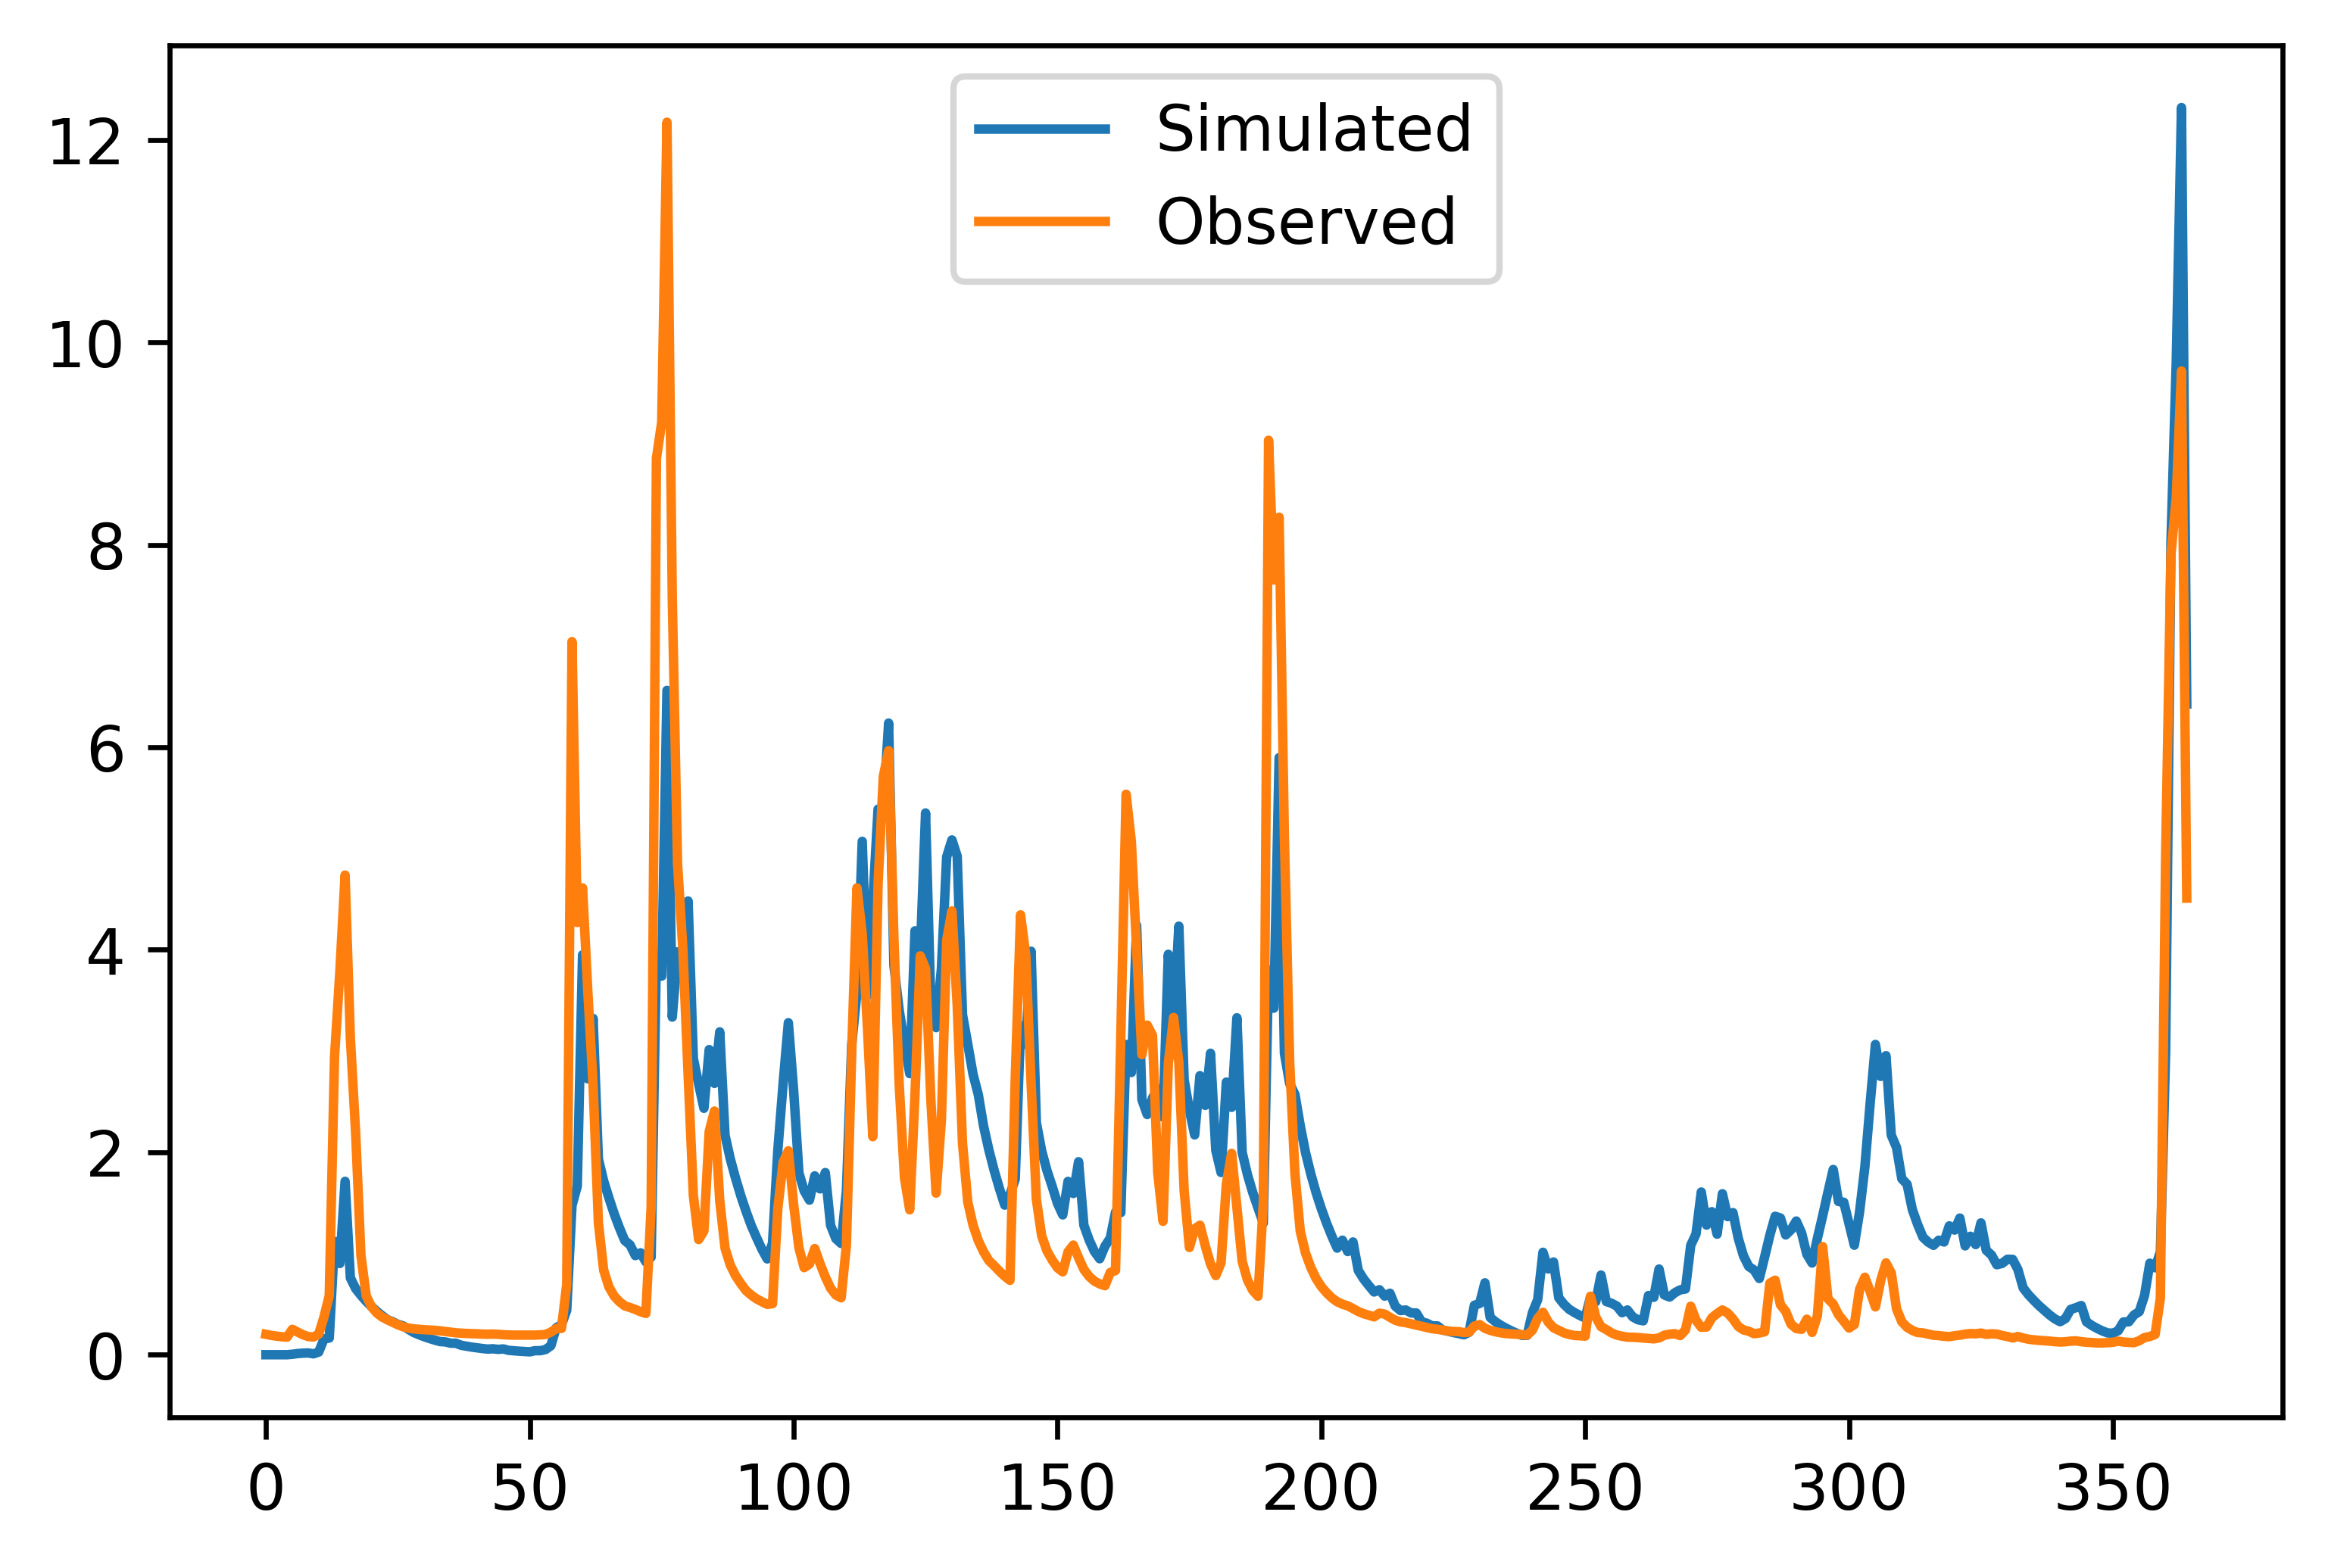

In [24]:
result = differential_evolution(hymod, bounds=bounds)
print(result)
Q = hymod(result.x, mode='simulate')
plt.plot(Q)
plt.plot(data_Q)
plt.legend(['Simulated', 'Observed'])
plt.show()

To run SA

In [25]:
problem = {
    'num_vars': 5,
    'names': ['Cmax', 'B', 'alpha', 'Kq', 'Ks'],
    'bounds': bounds
}

param_values = saltelli.sample(problem, 1024)
N = len(param_values) # number of parameter samples
Y = np.zeros(N)

/var/folders/d0/8bmn6nx130n6ljv_75rbjbnh0000gn/T/ipykernel_79343/2514766707.py:7: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


Run model for each parameter set, save the output in array Y

In [26]:
for i in range(N):
    if i % 1000 == 0:
        print(i)
    Y[i] = hymod(param_values[i])

Si = sobol.analyze(problem, Y, print_to_console=True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
             ST   ST_conf
Cmax   0.166218  0.033688
B      0.108469  0.023844
alpha  0.581513  0.115284
Kq     0.489474  0.087408
Ks     0.010738  0.002269
             S1   S1_conf
Cmax   0.100653  0.042670
B      0.070693  0.038204
alpha  0.309437  0.066151
Kq     0.203670  0.078787
Ks     0.004330  0.012078
                     S2   S2_conf
(Cmax, B)     -0.026565  0.071308
(Cmax, alpha)  0.003854  0.080688
(Cmax, Kq)     0.008925  0.082935
(Cmax, Ks)    -0.025451  0.067242
(B, alpha)    -0.001535  0.059652
(B, Kq)       -0.003865  0.063537
(B, Ks)       -0.014738  0.045742
(alpha, Kq)    0.168893  0.144778
(alpha, Ks)    0.002740  0.085859
(Kq, Ks)       0.005979  0.118986


----------